# **Setup**
First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

# Project 1 

QUESTION 3 
# Repeat all the experiments in 02_end_to_end_machine_learning_project.ipynb but use the Wine data set instead the housing data

In [0]:
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_wine_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# **Get The Data**

In [0]:
import os
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/minsh30/Project1/"
WINE_PATH = os.path.join("master", "")
WINE_URL = DOWNLOAD_ROOT + "master/wine.csv"

def fetch_wine_data(wine_url=WINE_URL, wine_path=WINE_PATH):
    if not os.path.isdir(wine_path):
        os.makedirs(wine_path)
    csv_path = os.path.join(wine_path, "wine.csv")
    urllib.request.urlretrieve(wine_url, csv_path)

fetch_wine_data()
   

In [0]:
import pandas as pd

def load_wine_data(wine_path=WINE_PATH):
    csv_path = os.path.join(wine_path, "wine.csv")
    return pd.read_csv(csv_path)

head shows top five elements of the dataset

In [121]:
wine_data = load_wine_data()
wine_data.head()

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total Phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [122]:
wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
Class                           178 non-null int64
Alcohol                         178 non-null float64
Malic  acid                     178 non-null float64
Ash                             178 non-null float64
Alcalinity of ash               178 non-null float64
Magnesium                       178 non-null int64
Total Phenols                   178 non-null float64
Flavanoids                      178 non-null float64
Nonflavanoid phenols            178 non-null float64
Proanthocyanins                 178 non-null float64
Color intensity                 178 non-null float64
Hue                             178 non-null float64
OD280/OD315 of diluted wines    178 non-null float64
Proline                         178 non-null int64
dtypes: float64(11), int64(3)
memory usage: 19.6 KB


In [123]:
wine_data["Class"].value_counts()

2    71
1    59
3    48
Name: Class, dtype: int64

In [124]:
wine_data.describe()

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total Phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,1.938202,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.775035,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,2.000000,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,3.000000,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


Saving figure attribute_histogram_plots


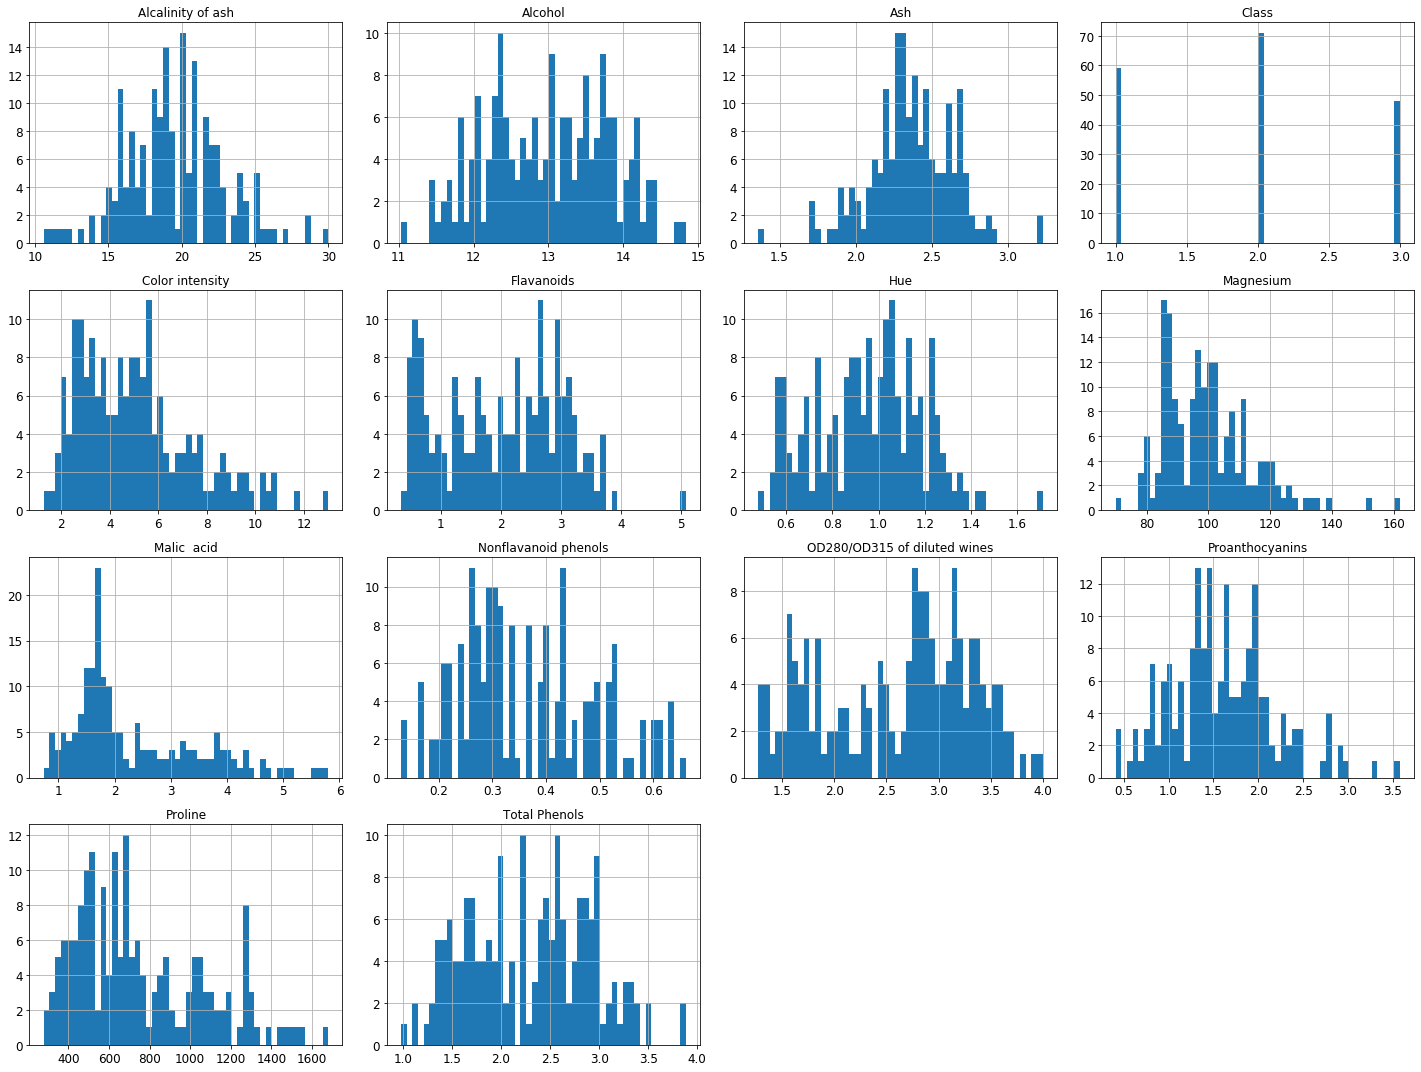

In [125]:
%matplotlib inline
import matplotlib.pyplot as plt
wine_data.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

In [0]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [0]:
import numpy as np

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [128]:
train_set, test_set = split_train_test(wine_data, 0.2)
len(train_set)

143

In [129]:
len(test_set)

35

In [0]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

The implementation of test_set_check() above works fine in both Python 2 and Python 3. In earlier releases, the following implementation was proposed, which supported any hash function, but was much slower and did not support Python 2:



In [0]:
import hashlib

def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

In [0]:
wine_with_id = wine_data.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(wine_with_id, 0.2, "Class")

In [0]:
wine_with_id["id"] = wine_data["Alcalinity of ash"] * 1000 + wine_data["Alcohol"]
train_set, test_set = split_train_test_by_id(wine_with_id, 0.2, "id")

In [134]:
test_set.head()

,index,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total Phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline,id
5,5,1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450,15214.20
10,10,1,14.10,2.16,2.30,18.0,105,2.95,3.32,0.22,2.38,5.75,1.25,3.17,1510,18014.10
15,15,1,13.63,1.81,2.70,17.2,112,2.85,2.91,0.30,1.46,7.30,1.28,2.88,1310,17213.63
17,17,1,13.83,1.57,2.62,20.0,115,2.95,3.40,0.40,1.72,6.60,1.13,2.57,1130,20013.83
18,18,1,14.19,1.59,2.48,16.5,108,3.30,3.93,0.32,1.86,8.70,1.23,2.82,1680,16514.19


In [0]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(wine_data, test_size=0.2, random_state=42)

In [136]:
test_set.head()

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total Phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
19,1,13.64,3.10,2.56,15.2,116,2.70,3.03,0.17,1.66,5.10,0.96,3.36,845
45,1,14.21,4.04,2.44,18.9,111,2.85,2.65,0.30,1.25,5.24,0.87,3.33,1080
140,3,12.93,2.81,2.70,21.0,96,1.54,0.50,0.53,0.75,4.60,0.77,2.31,600
30,1,13.73,1.50,2.70,22.5,101,3.00,3.25,0.29,2.38,5.70,1.19,2.71,1285
67,2,12.37,1.17,1.92,19.6,78,2.11,2.00,0.27,1.04,4.68,1.12,3.48,510


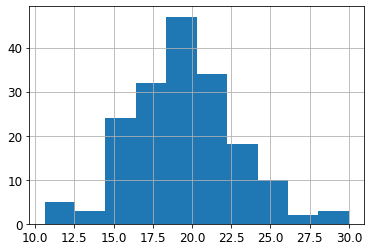

In [137]:
wine_data["Alcalinity of ash"].hist()

In [0]:
wine_data["Flavanoids"] = pd.cut(wine_data["Flavanoids"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [139]:
wine_data["Flavanoids"].value_counts()

2    87
1    60
3    30
4     1
5     0
Name: Flavanoids, dtype: int64

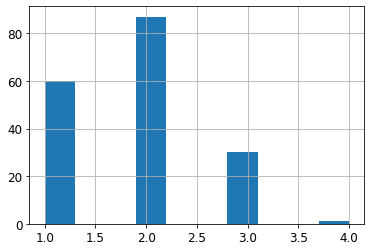

In [140]:
wine_data["Flavanoids"].hist()

#  Discover and visualize the data to gain insights

Saving figure bad_visualization_plot


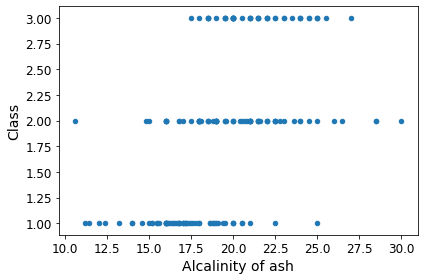

In [141]:
wine_data.plot(kind="scatter", x="Alcalinity of ash", y="Class")
save_fig("bad_visualization_plot")

Saving figure better_visualization_plot


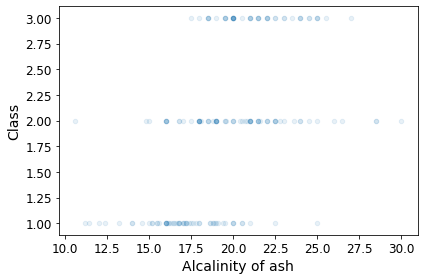

In [142]:
wine_data.plot(kind="scatter", x="Alcalinity of ash", y="Class", alpha=0.1)
save_fig("better_visualization_plot")

The argument sharex=False fixes a display bug (the x-axis values and legend were not displayed). This is a temporary fix (see: https://github.com/pandas-dev/pandas/issues/10611 ). Thanks to Wilmer Arellano for pointing it out.

Saving figure wine_scatterplot


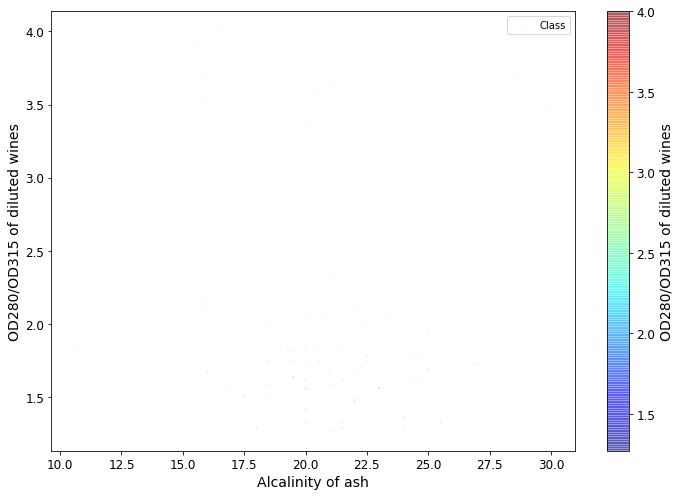

In [143]:
wine_data.plot(kind="scatter", x="Alcalinity of ash", y="OD280/OD315 of diluted wines", alpha=0.4,
    s=wine_data["Class"]/100, label="Class", figsize=(10,7),
    c="OD280/OD315 of diluted wines", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
save_fig("wine_scatterplot")

Correlation of attribute

In [0]:
corr_matrix = wine_data.corr()

In [145]:
corr_matrix["Class"].sort_values(ascending=False)

Class                           1.000000
Alcalinity of ash               0.517859
Nonflavanoid phenols            0.489109
Malic  acid                     0.437776
Color intensity                 0.265668
Ash                            -0.049643
Magnesium                      -0.209179
Alcohol                        -0.328222
Proanthocyanins                -0.499130
Hue                            -0.617369
Proline                        -0.633717
Total Phenols                  -0.719163
OD280/OD315 of diluted wines   -0.788230
Name: Class, dtype: float64

# When correlating with class highest correlation is Alcalinity of ash

Saving figure scatter_matrix_plot


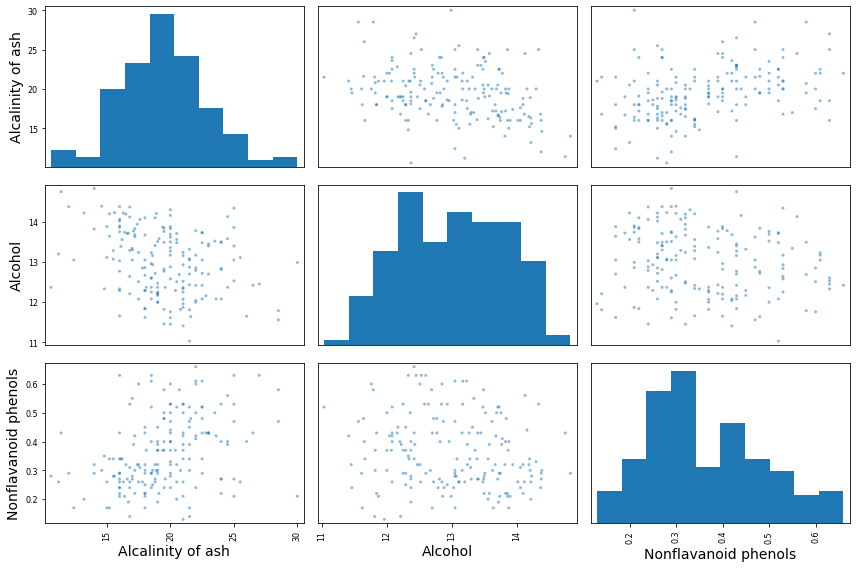

In [146]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["Alcalinity of ash", "Alcohol", "Flavanoids",
              "Nonflavanoid phenols"]
scatter_matrix(wine_data[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

Saving figure Alcalinity of ash_vs_Class_value_scatterplot


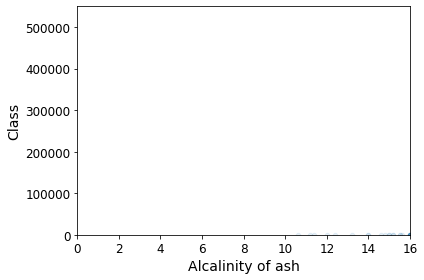

In [173]:
wine_data.plot(kind="scatter", x="Alcalinity of ash", y="Class",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("Alcalinity of ash_vs_Class_value_scatterplot")

In [149]:
corr_matrix = wine_data.corr()
corr_matrix["Alcalinity of ash"].sort_values(ascending=False)

Alcalinity of ash               1.000000
Class                           0.517859
Ash                             0.443367
Nonflavanoid phenols            0.361922
Malic  acid                     0.288500
Color intensity                 0.018732
Magnesium                      -0.083333
Proanthocyanins                -0.197327
Hue                            -0.273955
OD280/OD315 of diluted wines   -0.276769
Alcohol                        -0.310235
Total Phenols                  -0.321113
Proline                        -0.440597
Name: Alcalinity of ash, dtype: float64

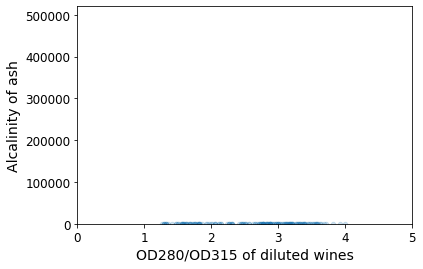

In [150]:
wine_data.plot(kind="scatter", x="OD280/OD315 of diluted wines", y="Alcalinity of ash",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

In [151]:
wine_data.describe()

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total Phenols,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,1.938202,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.775035,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,2.000000,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,3.000000,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


# Prepare the data for Machine Learning algorithms



In [152]:
sample_incomplete_rows = wine_data[wine_data.isnull().any(axis=1)].head()
sample_incomplete_rows

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total Phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline


sample_incomplete_rows.dropna(subset=["Flavanoids"])    # option 1

In [90]:
sample_incomplete_rows.drop("Flavanoids", axis=1)       # option 2

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total Phenols,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline


In [92]:
sample_incomplete_rows

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total Phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline


In [0]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [0]:
wine_num = wine_data.drop("Proline", axis=1)
# alternatively: wine_num = wine.select_dtypes(include=[np.number])

In [155]:
imputer.fit(wine_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [156]:
imputer.statistics_

array([ 2.   , 13.05 ,  1.865,  2.36 , 19.5  , 98.   ,  2.355,  2.   ,
        0.34 ,  1.555,  4.69 ,  0.965,  2.78 ])

In [157]:
wine_num.median().values

array([ 2.   , 13.05 ,  1.865,  2.36 , 19.5  , 98.   ,  2.355,  2.   ,
        0.34 ,  1.555,  4.69 ,  0.965,  2.78 ])

Transform the training set:

In [0]:
X = imputer.transform(wine_num)

In [160]:
imputer.strategy

'median'

In [0]:
wine_tr = pd.DataFrame(X, columns=wine_num.columns,
                          index=wine_num.index)

In [162]:
wine_tr.head()

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total Phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines
0,1.0,14.23,1.71,2.43,15.6,127.0,2.80,3.0,0.28,2.29,5.64,1.04,3.92
1,1.0,13.20,1.78,2.14,11.2,100.0,2.65,2.0,0.26,1.28,4.38,1.05,3.40
2,1.0,13.16,2.36,2.67,18.6,101.0,2.80,3.0,0.30,2.81,5.68,1.03,3.17
3,1.0,14.37,1.95,2.50,16.8,113.0,3.85,3.0,0.24,2.18,7.80,0.86,3.45
4,1.0,13.24,2.59,2.87,21.0,118.0,2.80,2.0,0.39,1.82,4.32,1.04,2.93


Now let's preprocess the categorical input feature, OD280/OD315 of diluted wines:

In [163]:
wine_cat = wine_data[["OD280/OD315 of diluted wines"]]
wine_cat.head(10)

,OD280/OD315 of diluted wines
0,3.92
1,3.40
2,3.17
3,3.45
4,2.93
5,2.85
6,3.58
7,3.58
8,2.85
9,3.55


In [164]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
wine_cat_encoded = ordinal_encoder.fit_transform(wine_cat)
wine_cat_encoded[:10]

array([[120.],
       [102.],
       [ 86.],
       [104.],
       [ 73.],
       [ 68.],
       [113.],
       [113.],
       [ 68.],
       [110.]])

In [165]:
ordinal_encoder.categories_

[array([1.27, 1.29, 1.3 , 1.33, 1.36, 1.42, 1.47, 1.48, 1.51, 1.55, 1.56,
        1.58, 1.59, 1.6 , 1.62, 1.63, 1.64, 1.67, 1.68, 1.69, 1.71, 1.73,
        1.74, 1.75, 1.78, 1.8 , 1.82, 1.83, 1.86, 1.92, 1.93, 1.96, 2.  ,
        2.01, 2.05, 2.06, 2.11, 2.12, 2.14, 2.15, 2.23, 2.26, 2.27, 2.3 ,
        2.31, 2.42, 2.44, 2.46, 2.47, 2.48, 2.5 , 2.51, 2.52, 2.57, 2.63,
        2.65, 2.69, 2.71, 2.72, 2.73, 2.74, 2.75, 2.77, 2.78, 2.81, 2.82,
        2.83, 2.84, 2.85, 2.87, 2.88, 2.9 , 2.91, 2.93, 2.96, 3.  , 3.02,
        3.03, 3.05, 3.07, 3.08, 3.1 , 3.12, 3.13, 3.14, 3.16, 3.17, 3.18,
        3.19, 3.2 , 3.21, 3.22, 3.26, 3.28, 3.3 , 3.31, 3.33, 3.35, 3.36,
        3.37, 3.38, 3.39, 3.4 , 3.44, 3.45, 3.47, 3.48, 3.5 , 3.52, 3.53,
        3.55, 3.56, 3.57, 3.58, 3.59, 3.63, 3.64, 3.69, 3.71, 3.82, 3.92,
        4.  ])]

In [166]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
wine_cat_1hot = cat_encoder.fit_transform(wine_cat)
wine_cat_1hot

<178x122 sparse matrix of type '<class 'numpy.float64'>'
	with 178 stored elements in Compressed Sparse Row format>

In [167]:
wine_cat_1hot.toarray()

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Alternatively, you can set sparse=False when creating the OneHotEncoder:

In [168]:
cat_encoder = OneHotEncoder(sparse=False)
wine_cat_1hot = cat_encoder.fit_transform(wine_cat)
wine_cat_1hot

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [169]:
cat_encoder.categories_

[array([1.27, 1.29, 1.3 , 1.33, 1.36, 1.42, 1.47, 1.48, 1.51, 1.55, 1.56,
        1.58, 1.59, 1.6 , 1.62, 1.63, 1.64, 1.67, 1.68, 1.69, 1.71, 1.73,
        1.74, 1.75, 1.78, 1.8 , 1.82, 1.83, 1.86, 1.92, 1.93, 1.96, 2.  ,
        2.01, 2.05, 2.06, 2.11, 2.12, 2.14, 2.15, 2.23, 2.26, 2.27, 2.3 ,
        2.31, 2.42, 2.44, 2.46, 2.47, 2.48, 2.5 , 2.51, 2.52, 2.57, 2.63,
        2.65, 2.69, 2.71, 2.72, 2.73, 2.74, 2.75, 2.77, 2.78, 2.81, 2.82,
        2.83, 2.84, 2.85, 2.87, 2.88, 2.9 , 2.91, 2.93, 2.96, 3.  , 3.02,
        3.03, 3.05, 3.07, 3.08, 3.1 , 3.12, 3.13, 3.14, 3.16, 3.17, 3.18,
        3.19, 3.2 , 3.21, 3.22, 3.26, 3.28, 3.3 , 3.31, 3.33, 3.35, 3.36,
        3.37, 3.38, 3.39, 3.4 , 3.44, 3.45, 3.47, 3.48, 3.5 , 3.52, 3.53,
        3.55, 3.56, 3.57, 3.58, 3.59, 3.63, 3.64, 3.69, 3.71, 3.82, 3.92,
        4.  ])]

# Example SciPy distributions for RandomizedSearchCV

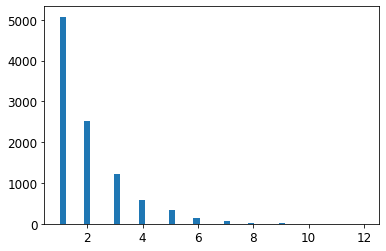

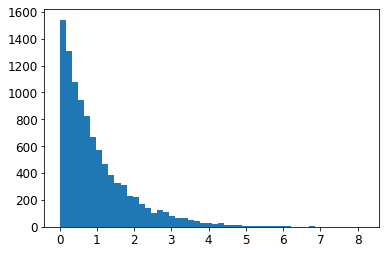

In [114]:
from scipy.stats import geom, expon
geom_distrib=geom(0.5).rvs(10000, random_state=42)
expon_distrib=expon(scale=1).rvs(10000, random_state=42)
plt.hist(geom_distrib, bins=50)
plt.show()
plt.hist(expon_distrib, bins=50)
plt.show()

Let's look at the exponential distribution we used, with scale=1.0. Note that some samples are much larger or smaller than 1.0, but when you look at the log of the distribution, you can see that most values are actually concentrated roughly in the range of exp(-2) to exp(+2), which is about 0.1 to 7.4.

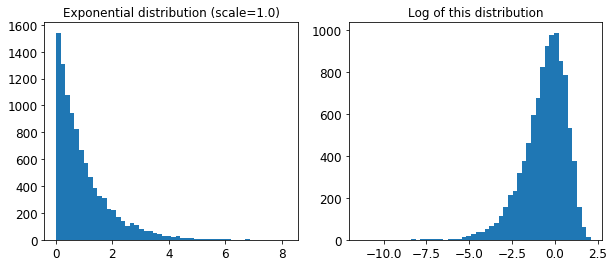

In [115]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()